# CS289A Project F NN

In [166]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(246810)
np.random.seed(246810)
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [167]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up dataset

In [168]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [169]:
dataset = "csmith_random_programs"
data = pd.read_csv('final_random.csv', delimiter=',')

### Part (a). Pre-process the data


In [178]:
# set out training set to be 70% of total; 30% 
# random_idx = random.randint(0, np.shape(data)[0]) #27
num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3
print(train_speedup)
# log_train_speedup = np.log10(train_speedup.astype(float))
# log_test_speedup = np.log10(test_speedup.astype(float))


(9011, 116)
(3862, 116)
(12873, 116)
[2915.27039334195 3064.5126890095776 3127.9902745113 ...
 2596.5991783791956 2804.3891404735623 3077.551395099053]


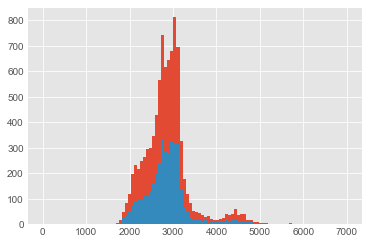

In [179]:
# EDA of speed up from training set
plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range = (0, 7000))

plt.show()


In [180]:
# Get binary preduction output: is speedup (HW vs SW) > 2800 
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1]
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1]
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

0.5433359227610698
0.5468669083376488


## Neural Net ##

In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [181]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 0)

In [147]:

#defining dataset class
from torch.utils.data import Dataset, DataLoader
class trainData(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
    
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

    
trainset = trainData(X_train,y)
test_data = testData(torch.FloatTensor(X_test))
validation_data = testData(torch.FloatTensor(X_val))

train_loader = DataLoader(trainset,batch_size=64,shuffle=False)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)
validation_loader = DataLoader(validation_data,batch_size=1,shuffle=False)

In [148]:
class Net(nn.Module):
    def __init__(self,input_shape,width = 64, depth = 3, activation = torch.relu):
        super(Net,self).__init__()
        self.width = width
        self.depth = depth
        self.activation = activation
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(input_shape,self.width))
        for _ in range(1,self.depth-1):
            self.layers.append(nn.Linear(width,self.width))
        self.layers.append(nn.Linear(self.width,1))
        
    def forward(self,x):
        for i in range(0,self.depth-1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [160]:
epochs = 500
lr_ = 0.001

def binary_acc(y_pred, y_test):
    """Helper function for getting the accuracy of a batch."""
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def train_model(model):
    """Train a model with the specified dimensions and activation fn."""
    optimizer = torch.optim.SGD(model.parameters(),lr=lr_)
    # Combines sigmoid and BCE in one class
    loss_fn = nn.BCEWithLogitsLoss()
    model.train()
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss/len(train_loader), epoch_acc/len(train_loader)
        
def evaluate_model(model, test_loader, y_test):
    """Return the accuracy on a test or validation set"""
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return np.mean(y_pred_list == y_test)

In [151]:
widths = [16, 32, 64]
depths = [2, 3, 4]
activations = {torch.relu : 'ReLU', torch.tanh : 'tanh'}
for width in widths:
    for depth in depths:
        for activation in activations.keys():
            # Model , Optimizer, Loss
            model = Net(input_shape=X_train.shape[1],width = width, depth = depth, activation = activation)
            model.to(device)
            train_loss, train_acc = train_model(model)
            validation_acc = evaluate_model(model, validation_loader, y_val)
            print(f'Width: {width}| Depth: {depth} | Activation: {activations[activation]} | Train Accuracy: {train_acc} | Validation Accuracy: {validation_acc}')

Width: 16| Depth: 2 | Activation: ReLU | Train Accuracy: 77.28368794326241 | Validation Accuracy: 0.7591921284308648
Width: 16| Depth: 2 | Activation: tanh | Train Accuracy: 77.09219858156028 | Validation Accuracy: 0.7591921284308648
Width: 16| Depth: 3 | Activation: ReLU | Train Accuracy: 77.0354609929078 | Validation Accuracy: 0.7607457276022787
Width: 16| Depth: 3 | Activation: tanh | Train Accuracy: 76.95744680851064 | Validation Accuracy: 0.7622993267736924
Width: 16| Depth: 4 | Activation: ReLU | Train Accuracy: 77.14893617021276 | Validation Accuracy: 0.7586742620403936
Width: 16| Depth: 4 | Activation: tanh | Train Accuracy: 77.09219858156028 | Validation Accuracy: 0.7622993267736924
Width: 32| Depth: 2 | Activation: ReLU | Train Accuracy: 77.38297872340425 | Validation Accuracy: 0.7659243915069912
Width: 32| Depth: 2 | Activation: tanh | Train Accuracy: 76.8936170212766 | Validation Accuracy: 0.7602278612118073
Width: 32| Depth: 3 | Activation: ReLU | Train Accuracy: 77.255319

In [182]:
# Include the validation set for training final model
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y, y_val))
trainset = trainData(X_train,y_train)
train_loader = DataLoader(trainset,batch_size=64,shuffle=False)

In [189]:
# Train best model
width = 32
depth = 2
activation = torch.relu
model = Net(input_shape=X_train.shape[1],width = width, depth = depth, activation = activation)
model.to(device)
train_model(model)

(0.5109115235986765, 77.45029239766082)

In [190]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [191]:
print(classification_report(y_test, y_pred_list))
print("Accuracy:")
print(np.mean(y_pred_list == y_test))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71       881
           1       0.74      0.87      0.80      1050

    accuracy                           0.76      1931
   macro avg       0.77      0.75      0.76      1931
weighted avg       0.77      0.76      0.76      1931

Accuracy:
0.7638529259451061
